# 双均线策略
本文主要介绍使用双均线策略对股票代号为600036的股票进行买入/卖出。步骤如下：
* 1.从Baostock上下载数据，清洗数据并存入本地
* 2.编写双均线策略
* 3.使用策略进行回测

### 参考：
* baostock数据的获取 http://baostock.com/baostock/index.php/A%E8%82%A1K%E7%BA%BF%E6%95%B0%E6%8D%AE
* 算法教学 (1).https://www.bilibili.com/video/BV1da4y1H7WL
* (2).https://www.bilibili.com/video/BV1i741147LS

# 1.数据预处理

In [39]:
import baostock as bs
import pandas as pd

In [40]:
class Get_data_from_baostock:
    
    def __init__(self, stock, start_date, end_date, freq, adjustflag):
        self.stock = stock
        self.start_date = start_date
        self.end_date = end_date
        self.freq = freq
        self.adjustflag = adjustflag
    
    def download_data_from_baostock(self):
        lg = bs.login()
        if str(self.stock)[0] == '6':
            stock_name = 'sh.' + str(self.stock)
        else:
            stock_name = 'sz.' + str(self.stock)
        
        if self.freq in ['d', 'w', 'm']:
            fields = "date,code,open,high,low,close,preclose,volume,amount,adjustflag,turn,tradestatus,pctChg,isST"
        else:
            fields = "date,time,code,open,high,low,close,volume,amount,adjustflag"
        
        rs = bs.query_history_k_data_plus(stock_name,
                                      fields,
                                      start_date = self.start_date, 
                                      end_date = self.end_date,
                                      frequency = str(self.freq), 
                                      adjustflag = str(self.adjustflag) # 2是前复权
                                     )
        bs.logout()
        
        df = pd.DataFrame(rs.data)
        df.columns = fields.split(',')
        
        df['open'] = [float(t) for t in df['open']]
        df['close'] = [float(t) for t in df['close']]
        df['high'] = [float(t) for t in df['high']]
        df['low'] = [float(t) for t in df['low']]  
        df['amount'] = [float(t) for t in df['amount']]
        df['volume'] = [float(t) for t in df['volume']]
        
        
        if self.freq in ['5','15','30','60']:
            df['time'] = [t[:-3] for t in df['time']] # 把毫秒去掉，否则int太长了无法转化为datatime格式
            df['time'] = pd.to_datetime(df['time'])
            df = df.loc[:, ['time','open','high','low','close','amount','volume']]
            df.rename(columns = {'time':'datetime'},inplace = True)
            df.set_index('datetime', drop=True, inplace = True) # 用时间作为index
        elif self.freq in ['d', 'w', 'm']:
            df = df.loc[:, ['date','open','high','low','close','amount','volume']]
            df['date'] = pd.to_datetime(df['date'])
            df.rename(columns = {'date':'datetime'},inplace = True)
            df.set_index('datetime', drop=True, inplace = True) # 用时间作为index
        else:
            print('k线时间输入错误')
            
        self.df = df
        return df
    
    def save_baostock_data_to_local(self,address):
        self.df.to_csv(address + '%s_%s.csv' % (self.stock,self.freq))
        print('文件已保存到'+ address + '%s_%s.csv' % (self.stock,self.freq))
        

In [41]:
GD = Get_data_from_baostock('603019','2020-01-01','2023-01-01','d','2')
data = GD.download_data_from_baostock()
address = 'E:/data/stock_data/'
GD.save_baostock_data_to_local(address)

login success!
logout success!
文件已保存到E:/data/stock_data/603019_d.csv


In [42]:
data.head()

,open,high,low,close,amount,volume
datetime,,,,,,
2020-01-02,24.643395,25.101058,24.502576,25.023607,8.835135e+08,24988392.0
2020-01-03,25.051771,25.178509,24.784214,25.150345,7.629039e+08,21478143.0
2020-01-06,24.960239,25.530557,24.840542,25.291164,1.031647e+09,28757030.0
2020-01-07,25.305246,25.530557,25.094017,25.523516,8.833146e+08,24522403.0
2020-01-08,25.354533,26.354351,25.284123,25.608008,1.539546e+09,42172080.0


# 2.双均线策略

In [43]:
data = data.loc[:,['open','close','high','low']]
data['ma5'] = data['open'].rolling(5).mean()
data['ma30'] = data['open'].rolling(30).mean()  
# 用rolling构建ma 
# 用open不用close是因为当天是看不到当头的收盘价的，只能用开盘价来预估金叉死叉
data.tail(10)

,open,close,high,low,ma5,ma30
datetime,,,,,,
2022-12-19,22.72,22.52,22.92,22.35,23.184,24.031667
2022-12-20,22.58,22.18,22.75,22.07,22.972,23.965667
2022-12-21,22.19,22.01,22.28,21.83,22.760,23.869000
2022-12-22,22.20,21.93,22.24,21.78,22.572,23.802667
2022-12-23,21.90,21.88,22.00,21.67,22.318,23.709333
2022-12-26,21.89,22.10,22.28,21.88,22.152,23.632333
2022-12-27,22.18,22.26,22.27,21.92,22.072,23.567667
2022-12-28,22.15,21.86,22.15,21.82,22.064,23.479000
2022-12-29,21.74,21.89,22.15,21.72,21.972,23.382000


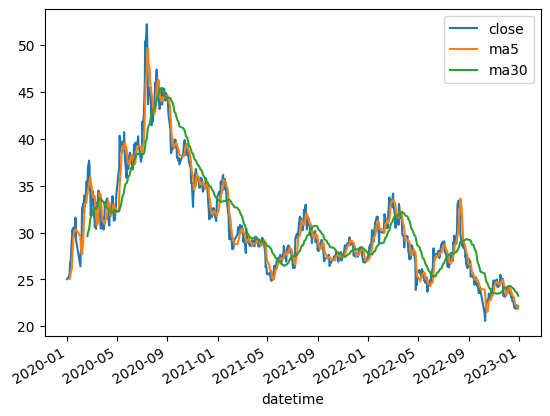

In [44]:
import matplotlib.pyplot as plt
data.loc[:,['close','ma5','ma30']].plot()
plt.show()

In [45]:
data = data.dropna()

In [46]:
# 计算金叉和死叉日期
# 以金叉为例子：金叉为ma5上穿ma30,data['ma5']<data['ma30']会有一段类似TTTTFFFFTTTT，
# 而data['ma5']>data['ma30']会有一段对应FFFFTTTTFFFF,此时把后面的序列shift1位，与第一序列相同的位置F即为金叉，T即为死叉
# TTTTFFFFTTTT
#  FFFFTTTTFFFF
sr1 = data['ma5'] < data['ma30']
sr2 = data['ma5'] >= data['ma30']
death_cross =  data[sr1 & sr2.shift(1)].index # &两个同时T才会是T,所以这个选的是死叉
death_cross

DatetimeIndex(['2020-03-11', '2020-03-24', '2020-04-15', '2020-04-28',
               '2020-06-11', '2020-07-29', '2020-08-13', '2020-09-04',
               '2021-01-27', '2021-04-13', '2021-04-27', '2021-07-05',
               '2021-08-18', '2021-12-01', '2022-03-11', '2022-03-24',
               '2022-07-13', '2022-08-19', '2022-11-29'],
              dtype='datetime64[ns]', name='datetime', freq=None)

In [47]:
golden_cross = data[~(sr1| sr2.shift(1))].index # or两个同时F才会是F,所以这个选的是金叉
golden_cross

DatetimeIndex(['2020-02-20', '2020-03-20', '2020-04-09', '2020-04-21',
               '2020-05-06', '2020-06-17', '2020-08-04', '2020-08-27',
               '2021-01-06', '2021-04-09', '2021-04-22', '2021-05-31',
               '2021-07-13', '2021-11-04', '2022-01-06', '2022-03-18',
               '2022-06-08', '2022-07-27', '2022-11-01'],
              dtype='datetime64[ns]', name='datetime', freq=None)

# 3.回测
假设在金叉全部买入，死叉全部卖出。这里不考虑其他规定(如要买/卖的数量是100的倍数，买/卖所收的手续费等等)，粗略计算一下这个策略在2022-01-01到2023-01-01的收益情况。

In [48]:
SR1 = pd.Series(1, index=golden_cross)
SR2 = pd.Series(0, index=death_cross)
SR = pd.concat([SR1,SR2],axis =0).sort_index()
SR

datetime
2020-02-20    1
2020-03-11    0
2020-03-20    1
2020-03-24    0
2020-04-09    1
2020-04-15    0
2020-04-21    1
2020-04-28    0
2020-05-06    1
2020-06-11    0
2020-06-17    1
2020-07-29    0
2020-08-04    1
2020-08-13    0
2020-08-27    1
2020-09-04    0
2021-01-06    1
2021-01-27    0
2021-04-09    1
2021-04-13    0
2021-04-22    1
2021-04-27    0
2021-05-31    1
2021-07-05    0
2021-07-13    1
2021-08-18    0
2021-11-04    1
2021-12-01    0
2022-01-06    1
2022-03-11    0
2022-03-18    1
2022-03-24    0
2022-06-08    1
2022-07-13    0
2022-07-27    1
2022-08-19    0
2022-11-01    1
2022-11-29    0
dtype: int64

In [49]:
first_money = 100000
money = first_money
hold = 0

for i in range(0,len(SR)):
    p = data['open'][SR.index[i]]
    if SR.iloc[i] == 1:
        buy = (money // (100 * p))
        hold += buy*100
        money -= buy*100*p
    else:
        money += hold * p
        hold = 0
        
p = data['open'][-1]
now_money = hold * p + money   

print(now_money - first_money)

-37344.44289799999
